# MNIST Classifications

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

### Load Data

In [2]:
df_raw = pd.read_pickle('results.pkl')
actual = df_raw.actual.copy()
preds = df_raw.xs('Prediction', level='Method', axis=1)
probs = df_raw.xs('Probability', level='Method', axis=1)
df_raw.head()

Classifier LogisticRegression             GaussianNB              LinearSVC  \
Method             Prediction Probability Prediction Probability Prediction   
0                         1.0    0.979908        1.0         1.0        1.0   
1                         1.0    0.968832        1.0         1.0        1.0   
2                         1.0    0.972728        1.0         1.0        1.0   
3                         1.0    0.999986        1.0         1.0        1.0   
4                         1.0    0.815760        1.0         1.0        1.0   

Classifier             RandomForestClassifier             SGDClassifier  \
Method     Probability             Prediction Probability    Prediction   
0             0.627873                    1.0         1.0           1.0   
1             0.574250                    1.0         1.0           1.0   
2             0.578030                    1.0         1.0           1.0   
3             0.775335                    1.0         1.0           1.0   
4             0.574944                    1.0         1.0           1.0   

Classifier             KNeighborsClassifier             actual  
Method     Probability           Prediction Probability         
0             0.626272                  1.0         1.0   True  
1             0.631219                  1.0         1.0   True  
2             0.629980                  1.0         1.0   True  
3             0.747994                  1.0         1.0   True  
4             0.549328                  1.0         1.0   True

### Basic Classifier Scores

In [3]:
# Display some summary data about the classifiers
from sklearn.metrics import (precision_recall_curve, brier_score_loss,
                             accuracy_score, precision_score, recall_score, f1_score,
                             average_precision_score, roc_curve, auc)

from functools import partial

pre = preds.agg(partial(precision_score, actual))
rec = preds.agg(partial(recall_score, actual))
acc = preds.agg(partial(accuracy_score, actual))
f_1 = preds.agg(partial(f1_score, actual))
total = preds.agg(sum)

stats = pd.DataFrame([total, acc, pre, rec, f_1], 
                     index=('Total', 'Accuracy', 'Precision', 'Recall', 'F1 Score'))
stats

Classifier,LogisticRegression,GaussianNB,LinearSVC,RandomForestClassifier,SGDClassifier,KNeighborsClassifier
Total,4961.000000,5476.000000,5159.000000,4857.000000,4339.000000,4872.000000
Accuracy,0.899500,0.800400,0.854300,0.970700,0.860700,0.985200
Precision,0.895182,0.767531,0.836209,0.976940,0.907121,0.990353
Recall,0.901543,0.853228,0.875761,0.963256,0.799026,0.979497
F1 Score,0.898351,0.808114,0.855528,0.970050,0.849649,0.984895


### Precision & Recall vs Threshold 

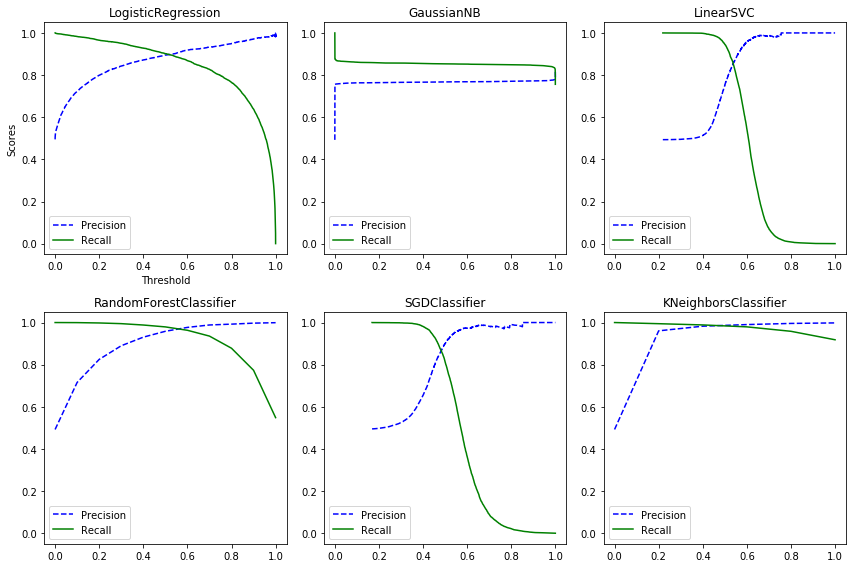

In [4]:
# Precision and Recall as they vary against Threshold
avg_precs = probs.agg(partial(average_precision_score, actual))
pr_curves = probs.agg(partial(precision_recall_curve, actual))

plt.figure(figsize=(12, 8))
axes = [plt.subplot2grid((2, 3), (m, n)) 
        for m in range(2)
        for n in range(3)]

for ax, (label, curve) in zip(axes, pr_curves.iteritems()):
    precisions, recalls, thresholds = curve
    ax.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    ax.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    ax.legend(loc='lower left')
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([-0.05, 1.05])
    ax.set_title(label)
    
axes[0].set_xlabel('Threshold')    
axes[0].set_ylabel('Scores')
plt.tight_layout()
plt.show()

### Precision-Recall and ROC Curves

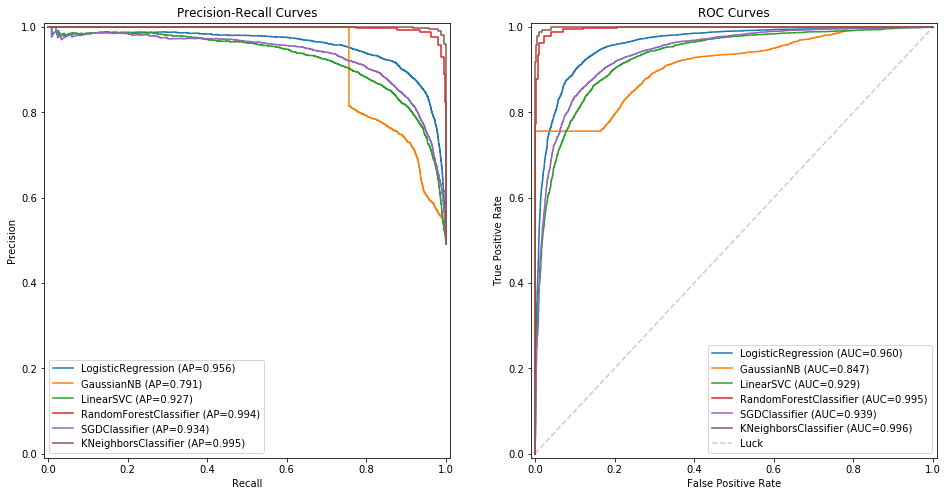

In [5]:
fig, (pr_plot, roc_plot) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

for plot in (pr_plot, roc_plot):
    plot.set_xlim([-0.01, 1.01])
    plot.set_ylim([-0.01, 1.01])

for label, (precisions, recalls, thresholds) in pr_curves.iteritems():
    ap = avg_precs[label]
    pr_plot.step(recalls, precisions, label=f'{label} (AP={ap:.3f})')

pr_plot.set_ylabel('Precision')
pr_plot.set_xlabel('Recall')
pr_plot.set_title('Precision-Recall Curves')
pr_plot.legend(loc='lower left')

roc_curves = probs.agg(partial(roc_curve, actual))
for label, (fpr, tpr, _) in roc_curves.iteritems():
    roc_plot.step(fpr, tpr, label=f'{label} (AUC={auc(fpr, tpr):.3f})')

roc_plot.plot([0, 1], [0, 1], 'k--', label='Luck', alpha=0.2)
roc_plot.set_ylabel('True Positive Rate')
roc_plot.set_xlabel('False Positive Rate')
roc_plot.set_title('ROC Curves')
roc_plot.legend(loc='lower right')

plt.show()

### Calibration

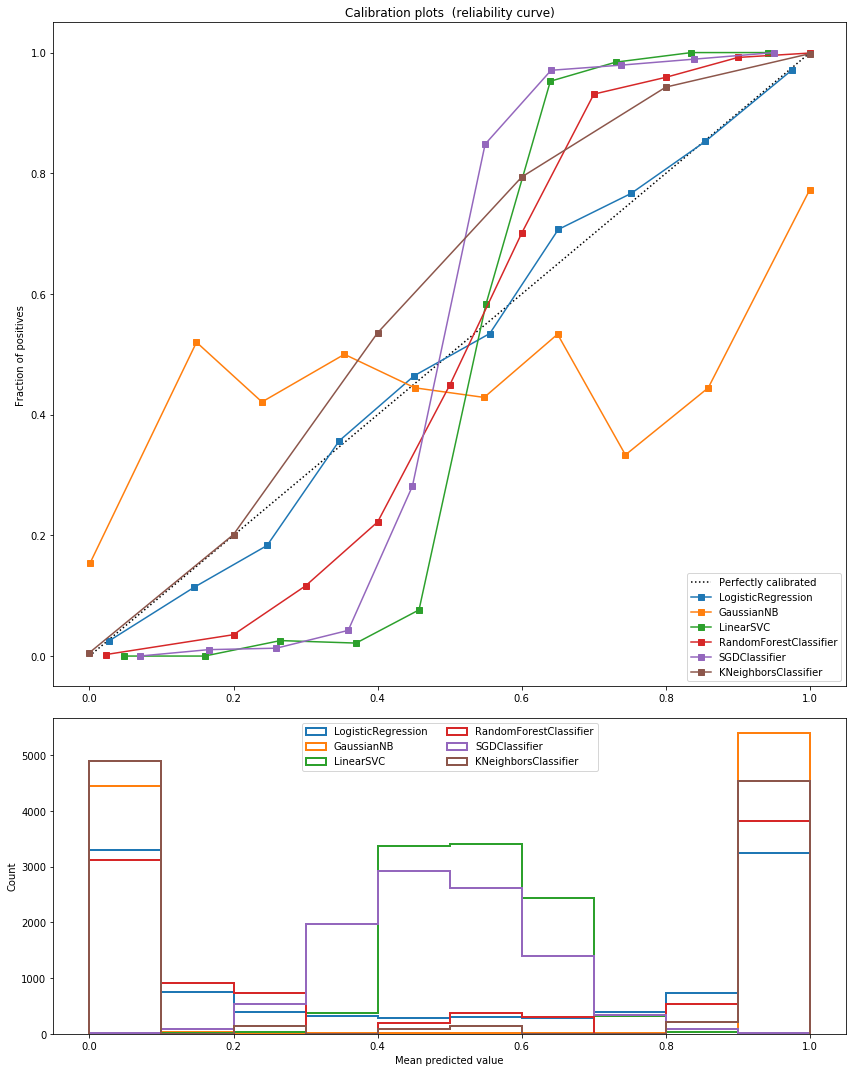

In [6]:
from sklearn.calibration import calibration_curve

cal_curves = probs.agg(partial(calibration_curve, actual, n_bins=10))

plt.figure(figsize=(12, 15))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for label, curve in cal_curves.iteritems():
    fraction_of_positives, mean_predicted_value = curve
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label=label)
    ax2.hist(probs[label], range=(0, 1), bins=10, label=label, histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()